In [1]:
import warnings
import sys
sys.path.insert(0, '../../src')
warnings.filterwarnings('ignore')

import ABC_train_test3
import network
import dataset
import sanityChecks
import torch 
import scrapbook as sb
from statistics import mean 
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,mean_absolute_error
import numpy as np
import pandas as pd 

In [2]:
# Read the dataset 
df = pd.read_csv('quadratic_constant_variance_dataset.csv')
df = df.iloc[: , 1:]
df.head()

,X0,X1,X2,X3,X4,Y
0,0.998824,0.688585,0.172086,0.516471,0.637355,25.691047
1,0.007501,0.714049,0.547857,0.841765,0.238708,29.859570
2,0.886862,0.763094,0.657418,0.354995,0.623382,41.162844
3,0.629512,0.538282,0.751046,0.549787,0.601327,49.251305
4,0.752578,0.266515,0.968932,0.674608,0.357547,57.438698


In [3]:
# Data Pre-processing 
scaler = preprocessing.StandardScaler()
df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
print(df.head())

# Get X and Y
n_features = 5
X = df.iloc[:,0:n_features]
Y = df.iloc[:,n_features]

#Add Constant 
X = X.to_numpy()
Y = Y.to_numpy()

         X0        X1        X2        X3        X4         Y
0  1.736673  0.638813 -1.017510 -0.115820  0.582693 -0.633851
1 -1.932069  0.727250  0.214785  1.171968 -0.883680 -0.329639
2  1.322319  0.897589  0.574079 -0.755078  0.531292  0.495255
3  0.369902  0.116791  0.881121  0.016070  0.450166  1.085538
4  0.825352 -0.827083  1.595655  0.510221 -0.446546  1.683040


In [4]:
#Train test split for dataset 
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size = 0.2)
train_data = dataset.CustomDataset(X_train,Y_train)
test_data = dataset.CustomDataset(X_test,Y_test)

In [5]:
# Training Parameters 
n_epochs = 1000
batch_size = 32 
#Select the device 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
# Fit the prior model and pre - generator 
variance = 1 # Constant Variance 

# Misspecified Prior Model
y_pred = ABC_train_test3.linear_model(X)
mae = mean_absolute_error(y_pred,Y)
sb.glue("Prior Model MAE",mae)
print("Prior Model MAE", mae)

# Pre-generator Model 
y_pred = ABC_train_test3.linear_model(X)
y_pred = y_pred + np.random.normal(0,variance,y_pred.shape)
mae = mean_absolute_error(y_pred,Y)
sb.glue("Pre-generator MAE", mae)
print("Pre-generator MAE", mae)


Prior Model MAE 13.790332135760542


Pre-generator MAE 13.840997549314139


##  mGAN 

In [7]:
gen = network.Generator(n_features+1).to(device)
disc = network.Discriminator(n_features+1).to(device)

criterion = torch.nn.BCELoss()
gen_opt = torch.optim.Adam(gen.parameters(), lr=0.001, betas=(0.5, 0.999))
disc_opt = torch.optim.Adam(disc.parameters(), lr=0.001, betas=(0.5, 0.999))

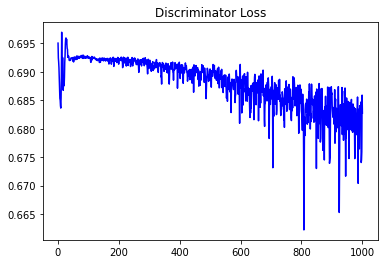

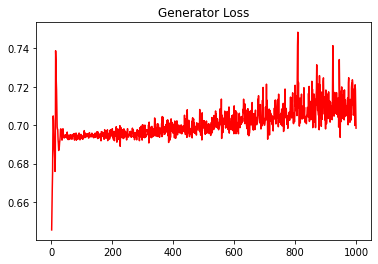

In [8]:
#Training the ABC_GAN 
ABC_train_test3.training_GAN(disc,gen,disc_opt,gen_opt,train_data,batch_size,n_epochs,criterion,ABC_train_test3.linear_model,variance,device)

In [10]:
ABC_GAN1_metrics=ABC_train_test3.test_generator(gen,test_data,ABC_train_test3.linear_model,variance,"1",device)
sb.glue("ABC_GAN_1 Metrics",ABC_GAN1_metrics)

print("MAE")
print(mean(ABC_GAN1_metrics[1]))

MAE
0.11857362063229084


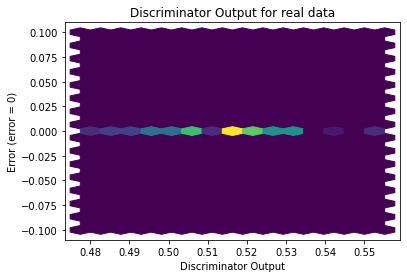

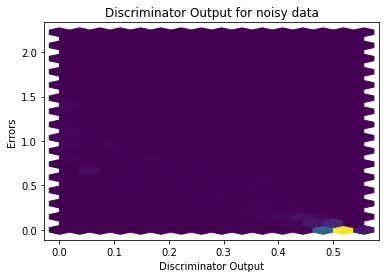

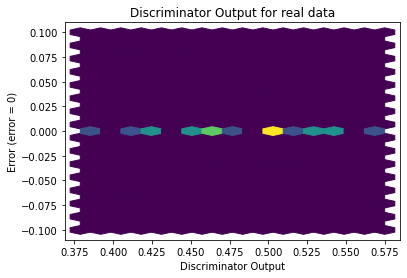

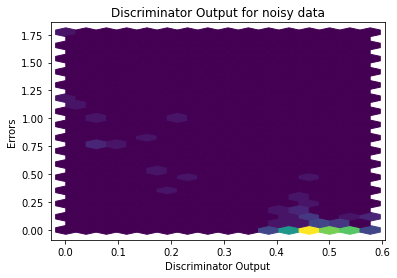

In [11]:
sanityChecks.discProbVsError(train_data,disc,device)
sanityChecks.discProbVsError(test_data,disc,device)

# ABC - GAN Model with skip connection

In [12]:
#Generator
gen3 = network.GeneratorWithSkipConnection(n_features+1).to(device)
constraints=network.weightConstraint()
#Discriminator 
disc3 = network.Discriminator(n_features+1).to(device)

criterion = torch.nn.BCELoss()
gen_opt = torch.optim.Adam(gen3.parameters(), lr=0.001, betas=(0.5, 0.999))
disc_opt = torch.optim.Adam(disc3.parameters(), lr=0.001, betas=(0.5, 0.999))


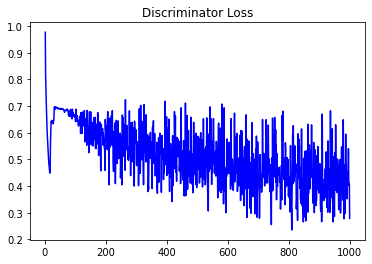

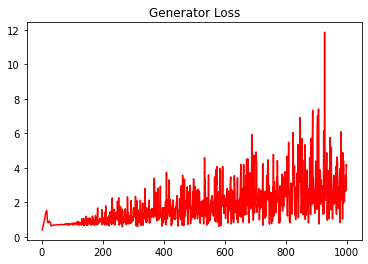

In [13]:
ABC_train_test3.training_GAN_skip_connection(disc3,gen3,disc_opt,gen_opt,train_data,batch_size,n_epochs,criterion,ABC_train_test3.linear_model,variance,device)

In [15]:
ABC_GAN3_metrics=ABC_train_test3.test_generator(gen3,test_data,ABC_train_test3.linear_model,variance,"3",device)
sb.glue("ABC_GAN_3 Metrics",ABC_GAN3_metrics)

print("MAE")
print(mean(ABC_GAN3_metrics[1]))

MAE
0.6936138860471547


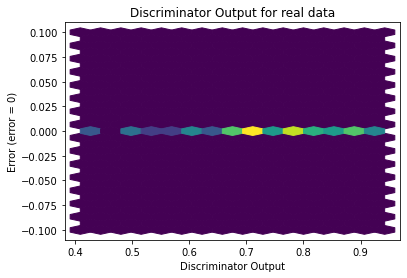

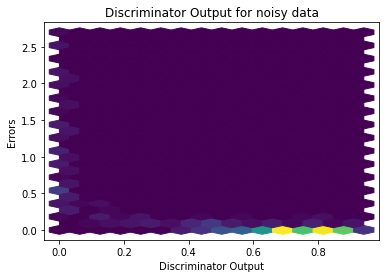

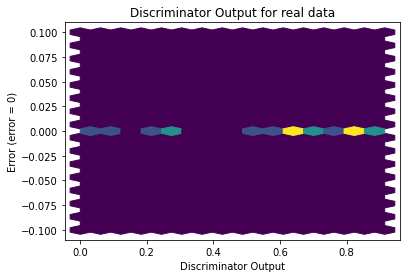

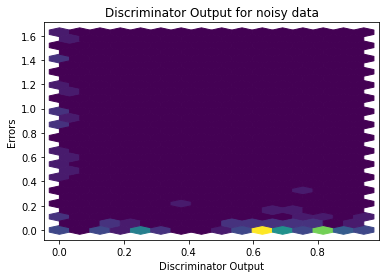

In [16]:
sanityChecks.discProbVsError(train_data,disc3,device)
sanityChecks.discProbVsError(test_data,disc3,device)

## Skip Connection Model Analysis - ABC-GAN 

### Weight Analysis 

Study the weights of the skip connection layer

Equation of the skip connection is 

$output = y_{gan} * w + y_{abc} * (1-w)$

In [17]:
print("Weight of the node at skip connection")
for name,param in gen3.named_parameters():
    if(name == "skipNode.weight"):
        print(param)
        sb.glue("Skip Connection Weight",param.item())

Weight of the node at skip connection
Parameter containing:
tensor([[0.1035]], requires_grad=True)
